# Amazon Apparel Recommendation

In [1]:
import numpy as np
import pandas as pd
import pickle


# OverView of the Data

In [ ]:
dataframe = pd.read_json("tops_fashion.json")
dataframe.head()

# 1 Data Preprocessing

 ## 1.1 Determining the size of the Data
     Here we take only seven important columns which will influence our recommendation system . 
     The seven columns are :
         "asin"
         "brand"
         "color"
         "product_type_name"
         "medium_image_url"
         "title"
         "formatted_price"

         


In [ ]:
dataframe = dataframe.loc[:,["asin","brand","color","product_type_name","medium_image_url","title","formatted_price"]]
dataframe.shape

## 1.2 Removal of rows which have value None in some columns and rows
   We will filter the rows whose value in the corresponding columns "title","formatted_price" and "color" are None .
   It reduces the size to ~28000 .
   We store it in a pickle file .

In [ ]:
df = dataframe.dropna(axis = 0, how = 'any', subset = ["title","formatted_price","color"])
print(df.shape)
df.to_pickle('pickels/28k_apparel')

## 1.3 Filtering Rows Whose Title has less then 5 words
    It reduces the data to ~ 27000 .
    We store it in the pickle file .

In [ ]:
def CountWords(sentences):
    sentences = sentences.split()
    count = 0
    for words in sentences:
        count += 1
    return count

In [ ]:
df = df[df["title"].apply(CountWords)>5]
print(df.shape)
df.to_pickle('pickels/27k_apparel')

## 1.4 De-Duplication of the Data 
    Steps for de-duping data
        1. We Sort the whole data based on title alphabetically This will help capture size and title discrepancies
        2.We Put all words in T1 in a set and all words of T2 in a set then apply set difference if they differ in 
        <=2  words 
        3.After this around 17593 data points will be left  = 17K apparel
        4.Here it is very important for you to look at data :
            Women v/s Ladies similarity
                  Not good if we recommend title 2 corresponding to title 1. This is like being near duplicates not                     exactly duplicates


        5.After this size reduces to 16K products


In [ ]:
df = df.sort_values(by='title')
df.head()

In [ ]:
indices = []
for i,row in df.iterrows():
    indices.append(i)



In [ ]:
import itertools
stage1 = []
i = 0
j = 0
num_of_rows = df.shape[0]
while i < num_of_rows and j < num_of_rows:
    prev_i = i
    a = df['title'].loc[indices[i]].split()
    j = i+1
    while j < num_of_rows:
        b = df['title'].loc[indices[j]].split()
        length = max(len(a), len(b))
        count  = 0
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1
        if (length - count) > 2: 
            stage1.append(df['asin'].loc[indices[i]])
            if j == num_of_rows-1: 
                stage1.append(df['asin'].loc[indices[j]])
            i = j
            break
        else:
            j += 1
    if prev_i == i:
        break

In [ ]:
df = df[df['asin'].isin(stage1)]
print(df.shape)
df.to_pickle('pickels/17k_apparel')

In [ ]:
indices = []
for i,row in df.iterrows():
    indices.append(i)
stage2 = []
while len(indices)!=0:
    i = indices.pop()
    stage2.append(df['asin'].loc[i])
    a = df['title'].loc[i].split()
    for j in indices:
        b = df['title'].loc[j].split()
        length = max(len(a),len(b))
        count = 0
        for k in itertools.zip_longest(a,b):
            if(k[0]==k[1]):
                count += 1
        if((length-count)<3):
            indices.remove(j)

In [ ]:
df = df[df['asin'].isin(stage2)]
print(df.shape)
df.to_pickle('pickels/16k_apparel')
       
        
    

# 2 . Text Based Reccomendation System

In [2]:
data = pd.read_pickle('pickels/16k_apperal_data')
data.shape

(16042, 7)

In [3]:
data['title'] = data['title'].str.lower()
len(data)


16042

In [4]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
corpus = []
for i in range(0,len(data)):
    title = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['title'])
    title = title.lower()
    title = title.split()
    title = ' '.join(title)
    data.iloc[i]['title'] = title
data.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/krishanukashyap/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,women s unique cotton t special olympics world...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean and castiel o nec...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_title = TfidfVectorizer(min_df = 0)
tfidf_feature_title = tfidf_title.fit_transform(data['title'])
tfidf_feature_title.shape


(16042, 9737)

In [6]:
'''
from collections import Counter 
def text2vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    return Counter(words) 
def get_result(data_id, content1, content2):
    text1 = content1
    text2 = content2
    vector1 = text2vector(text1)
    vector2 = text2vector(text2)
'''

"\nfrom collections import Counter \ndef text2vector(text):\n    word = re.compile(r'\\w+')\n    words = word.findall(text)\n    return Counter(words) \ndef get_result(data_id, content1, content2):\n    text1 = content1\n    text2 = content2\n    vector1 = text2vector(text1)\n    vector2 = text2vector(text2)\n"

ASIN : B073WKCX36
Brand: Fjallraven
Title: fjallraven women s alphabotanical t shirt lily m
Image: 


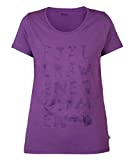

Euclidean similarity with the query image : 0.0
ASIN : B06XC3CZF6
Brand: Fjallraven
Title: fjallraven women s ovik t shirt plum xxl
Image: 


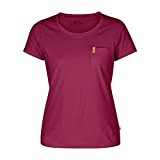

Euclidean similarity with the query image : 2.5421404731507615
ASIN : B06XDD9XX6
Brand: Fjallraven
Title: fjallraven women s meadow t shirt green xxs
Image: 


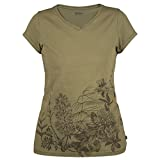

Euclidean similarity with the query image : 2.546141777391603
ASIN : B01GXAZT4C
Brand: Tony Arden
Title: chicago chicago women t shirt blue
Image: 


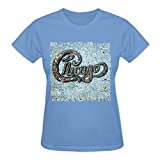

Euclidean similarity with the query image : 2.8772682252353845
ASIN : B01GXAZTRY
Brand: Tony Arden
Title: chicago chicago t shirt women pink
Image: 


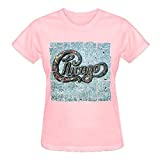

Euclidean similarity with the query image : 2.896386515959134
ASIN : B06X19BNJB
Brand: Fjallraven
Title: fjallraven women s ovik t shirt ocean mist xs
Image: 


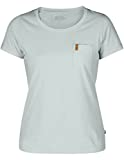

Euclidean similarity with the query image : 2.9336279480070164
ASIN : B01NBTWIOM
Brand: Fjallraven
Title: fjallraven women s ovik longsleeve top navy xs
Image: 


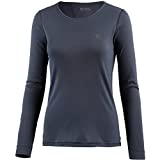

Euclidean similarity with the query image : 3.0642127919988056
ASIN : B01ND0FEE9
Brand: Weston
Title: weston women s lily tank multi color large
Image: 


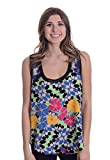

Euclidean similarity with the query image : 3.10113748825736
ASIN : B005IT8OBA
Brand: Hetalia
Title: hetalia u s girl t shirt m
Image: 


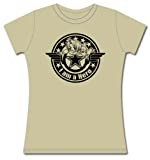

Euclidean similarity with the query image : 3.178258895563687
ASIN : B072YLH4NS
Brand: BURBERRY
Title: burberry women s white v neck t shirt l
Image: 


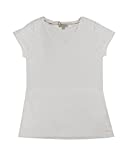

Euclidean similarity with the query image : 3.2194431462933295
ASIN : B01GXAZPRS
Brand: Tony Arden
Title: chicago chicago woman s t shirt black
Image: 


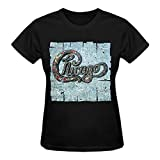

Euclidean similarity with the query image : 3.220489473850521
ASIN : B01H51HDN8
Brand: Tony Arden
Title: duran duran greatest women t shirt white
Image: 


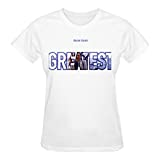

Euclidean similarity with the query image : 3.2205394511501284
ASIN : B01H51HH6G
Brand: Tony Arden
Title: duran duran greatest t shirt women white
Image: 


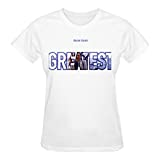

Euclidean similarity with the query image : 3.2205394511501284
ASIN : B0749P1W78
Brand: MISOOK
Title: misook womens misook tank m
Image: 


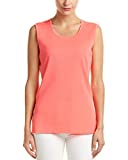

Euclidean similarity with the query image : 3.2372648074400003
ASIN : B0713Q513M
Brand: CBK
Title: cbk t shirt ambre women m white
Image: 


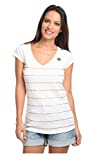

Euclidean similarity with the query image : 3.2574620746647347
ASIN : B074KBRNX5
Brand: Sunshine
Title: women s v neck sexy mature t shirt
Image: 


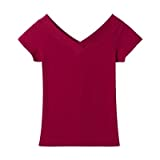

Euclidean similarity with the query image : 3.2623241125240527
ASIN : B01CK3TYW4
Brand: Fenini
Title: women s fenini black patch shirt x
Image: 


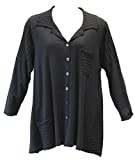

Euclidean similarity with the query image : 3.2767052394970784
ASIN : B007TVDEG0
Brand: Tokidoki
Title: tokidoki harmony women s shirt small
Image: 


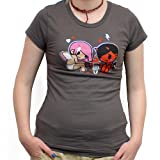

Euclidean similarity with the query image : 3.2814882138623758
ASIN : B01N5OKGNQ
Brand: Fjällräven
Title: fjallraven women s abisko trail t shirt print dark grey xl
Image: 


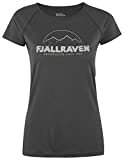

Euclidean similarity with the query image : 3.2984115322272967
ASIN : B072L1N7TN
Brand: CBK
Title: cbk t shirt maria women s green
Image: 


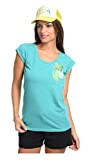

Euclidean similarity with the query image : 3.3234513506461605


In [25]:
from IPython.display import display, Image, SVG, Math, YouTubeVideo
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels

from sklearn.metrics.pairwise import manhattan_distances
def tfIdf_model(data_id, numOfResults):
    pairwise_dist = manhattan_distances(tfidf_feature_title,tfidf_feature_title[data_id])
    indices = np.argsort(pairwise_dist.flatten())[0:numOfResults]
    pdists  = np.sort(pairwise_dist.flatten())[0:numOfResults]
    df_indices = list(data.index[indices])
    for i in range(0,len(indices)):
        #get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]],)
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print('Image: ')
        display(Image(url=data['medium_image_url'].loc[df_indices[i]],embed = True ))
        print('Euclidean similarity with the query image :', pdists[i])
        print('='*60)
tfIdf_model(16, 20)

ASIN : B01M0LJ7TI
Brand: Minga London
Title: babe unitard jumpsuit playsuit womens tumblr pink print barbie kawaii
Image: 


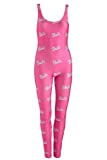

Euclidean similarity with the query image : 0.0
ASIN : B010N22ZUM
Brand: EnergieNYC
Title: energie nyc black juniors ruched muscle tee large
Image: 


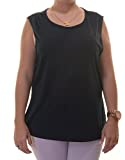

Euclidean similarity with the query image : 0.0
ASIN : B073PH7KNV
Brand: Haute Rogue
Title: haute rogue womens embroidered seersucker tunic top s blue
Image: 


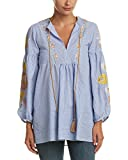

Euclidean similarity with the query image : 0.0
ASIN : B01H5X6V7U
Brand: Hometown Clothing
Title: bundle soft flowy tank top lightweight off coupon white xxl
Image: 


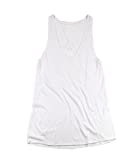

Euclidean similarity with the query image : 0.0
ASIN : B016WP84OA
Brand: Grace Elements
Title: grace elements ladies large short sleeve ruffle edge top hawaiian sea white
Image: 


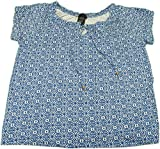

Euclidean similarity with the query image : 0.0
ASIN : B01HER0574
Brand: Xuguanghui
Title: female max cars logo t shirts xxl
Image: 


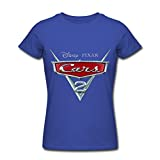

Euclidean similarity with the query image : 0.0
ASIN : B00HKXHAQM
Brand: Lauren Jeans Co.
Title: lauren jeans co blue sleeveless blouse pt s
Image: 


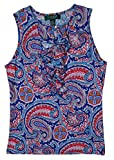

Euclidean similarity with the query image : 0.0
ASIN : B01NCJ5PRX
Brand: Mogul Interior
Title: womens strap top blue embriodered sexy dress m
Image: 


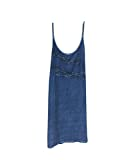

Euclidean similarity with the query image : 0.0
ASIN : B00ED34R3Q
Brand: None
Title: pizzazz performance wear hpkblk ys youth panel top with keyhole hot pink with black youth small
Image: 


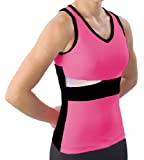

Euclidean similarity with the query image : 0.0
ASIN : B072BK2FDJ
Brand: Exotic India
Title: exotic india jet black kashmiri jacket with ari hand embroidered maple leaves
Image: 


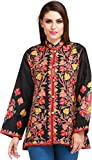

Euclidean similarity with the query image : 0.0
ASIN : B06XX6ZPTX
Brand: Material Girl
Title: material girl festival fuscha top blouse sleeveless size m nwt movaz
Image: 


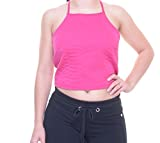

Euclidean similarity with the query image : 0.0
ASIN : B01MRZHU66
Brand: Dolce & Gabbana
Title: dolce gabbana white cotton top
Image: 


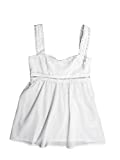

Euclidean similarity with the query image : 0.0
ASIN : B06WGW7R5H
Brand: Qingsun
Title: qingsun woman s fake necklace choker collar beads rhinestones fake false lace doll detachable collar white
Image: 


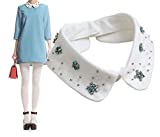

Euclidean similarity with the query image : 0.0
ASIN : B00IK50R64
Brand: Tory Burch
Title: tory burch blouse pink shell gracelynn tunic top size
Image: 


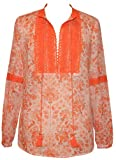

Euclidean similarity with the query image : 0.0
ASIN : B015UQ78DA
Brand: Kristine Accessories
Title: kristine accessories sassy anytime tunic red s m
Image: 


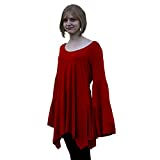

Euclidean similarity with the query image : 0.0
ASIN : B00C9EW9UY
Brand: Cypress Collectibles Embroidered Patches
Title: large australia flag embroidered patch australian iron on national emblem
Image: 


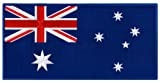

Euclidean similarity with the query image : 0.0
ASIN : B074T2ZBL7
Brand: Soft Joie
Title: soft joie womens cenna top xs beige
Image: 


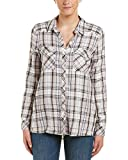

Euclidean similarity with the query image : 0.0
ASIN : B01E0PZWOE
Brand: Sacred Threads
Title: embroidered top w lace sleeves one size navy blue
Image: 


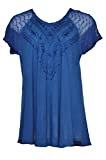

Euclidean similarity with the query image : 0.0
ASIN : B072XMKT6G
Brand: Ten Sixty Sherman
Title: ten sixty sherman large i was just thinking graphic tee black l
Image: 


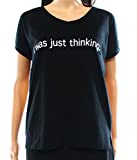

Euclidean similarity with the query image : 0.0
ASIN : B07428GLQ7
Brand: Sacred Threads
Title: sacred threadscaftan embroidery drawstring trendy top xs
Image: 


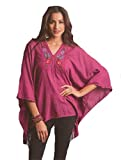

Euclidean similarity with the query image : 0.0


In [27]:
from IPython.display import display, Image, SVG, Math, YouTubeVideo
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import cosine_similarity
def tfIdf_model(data_id, numOfResults):
    pairwise_dist = cosine_similarity(tfidf_feature_title,tfidf_feature_title[data_id])
    indices = np.argsort(pairwise_dist.flatten())[0:numOfResults]
    pdists  = np.sort(pairwise_dist.flatten())[0:numOfResults]
    df_indices = list(data.index[indices])
    for i in range(0,len(indices)):
        #get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]],)
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print('Image: ')
        display(Image(url=data['medium_image_url'].loc[df_indices[i]],embed = True ))
        print('Euclidean similarity with the query image :', pdists[i])
        print('='*60)
tfIdf_model(16, 20)

# 3. Image Based Reccomendation System

In [8]:
ModifiedDataAsin = np.load('16k_data_cnn_feature_asins.npy')


In [9]:
ModifiedDataPostCNN = np.load('16k_data_cnn_features.npy')
data = pd.read_pickle('pickels/16k_apperal_data')
print(ModifiedDataPostCNN.shape)
print(data.shape)

(16042, 25088)
(16042, 7)


In [10]:
ModifiedDataAsin = list(ModifiedDataAsin)

'Image:'

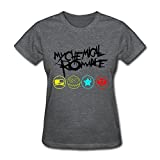

Title : Women's Cute Tshirt - My Chemical Romance DeepHeather Size M
Distance from the Query image : 1.9073486e-06
**********************************************************************


'Image:'

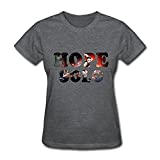

Title : HUBA Women's Tees Hope Solo DeepHeather Size XS
Distance from the Query image : 18.706451
**********************************************************************


'Image:'

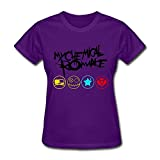

Title : Women's Cute Tshirts - My Chemical Romance Purple Size XXL
Distance from the Query image : 20.165726
**********************************************************************


'Image:'

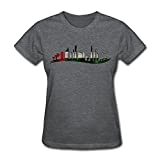

Title : ZEKO Women's Tees The United Arab Emirates Flag Dubai Size L DeepHeather
Distance from the Query image : 20.853035
**********************************************************************


'Image:'

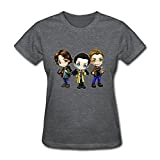

Title : Supernatural Chibis Sam Dean And Castiel Cotton T Shirts For Women's DeepHeather XXL
Distance from the Query image : 21.078283
**********************************************************************


'Image:'

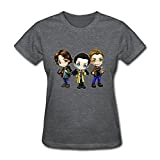

Title : Supernatural Chibis Sam Dean And Castiel Cotton T-Shirt For Women DeepHeather XL
Distance from the Query image : 21.078283
**********************************************************************


'Image:'

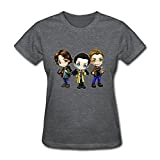

Title : Supernatural Chibis Sam Dean And Castiel O Neck T Shirt For Female DeepHeather L
Distance from the Query image : 21.078283
**********************************************************************


'Image:'

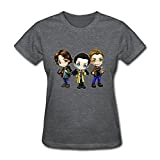

Title : Supernatural Chibis Sam Dean And Castiel Organic Cotton T Shirts For Women's DeepHeather M
Distance from the Query image : 21.078283
**********************************************************************


'Image:'

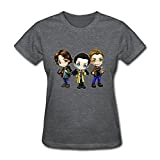

Title : Supernatural Chibis Sam Dean And Castiel Slim Fit T-Shirt For Women DeepHeather XS
Distance from the Query image : 21.078283
**********************************************************************


'Image:'

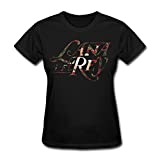

Title : SHJQ Women's Tshirt Cute Lana Del Rey Black Size M
Distance from the Query image : 22.077589
**********************************************************************


In [11]:
from IPython.display import display, Image, SVG, Math, YouTubeVideo
from sklearn.metrics import pairwise_distances
df_asins = list(data['asin'])
def ImageBasedReccomendation(data_id, numOfResults):
    data_id = ModifiedDataAsin.index(df_asins[data_id])
    PairWiseFunction = pairwise_distances(ModifiedDataPostCNN,ModifiedDataPostCNN[data_id].reshape(1,-1))
    indices = np.argsort(PairWiseFunction.flatten())[0:numOfResults]
    distances = np.sort(PairWiseFunction.flatten())[0:numOfResults]
    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin'] == ModifiedDataAsin[indices[i]]]
        for index,row in rows.iterrows():
            display("Image:",Image(url=row['medium_image_url'], embed=True))
            print("Title :",row['title'])
            print("Distance from the Query image :",distances[i])
            print('*'*70)
            
    
ImageBasedReccomendation(124, 10)